# Task 2 - Naive Bayes: Ham/Spam

In [1]:
# Librerias base
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt



## 2.1 Lectura y limpieza del dataset

In [2]:
#cargar los datos 
with open("entrenamiento.txt", "r", encoding="utf-8") as f:
    lines = f.readlines()

#separar la categoria y el mensaje  del dataset
data =[]
for line in lines: 
    category, message = line.strip().split("\t",1)
    data.append([category, message])

#crear el dataframe
df = pd.DataFrame(data, columns=["category", "message"])


In [3]:
#exploracion de los datos
print("\nexploracion de los datos: ")
print("\nmostrar las primeras filas: ")
print(df.head())

#resumen del set de datos
print("\nresumen: ")
print(df.describe())

#obtener el tipo de datos
print("\n tipo de datos: ")
print(df.dtypes)



exploracion de los datos: 

mostrar las primeras filas: 
  category                                            message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...

resumen: 
       category                 message
count      5565                    5565
unique        2                    5153
top         ham  Sorry, I'll call later
freq       4818                      30

 tipo de datos: 
category    object
message     object
dtype: object


In [4]:
#limpieza de los datos
print("\nlimpieza de los datos: ")

#reemplazar valores vacios
df = df.replace(r'^\s*$', np.nan, regex=True)

#eliminar filas con valores nulos
df = df.dropna()

#revision de valores duplicados
print("\nencontar valores duplicados: ")
print(df.duplicated().sum())

#eliminar valores duplicados

df = df.drop_duplicates()

#revision de valores nulos despues de la limpieza
print("\nrevision de valores nulos despues de la limpieza: ")
print(df.isnull().sum())

#cambiar los datos a todo minuscula
df['message'] = df['message'].str.lower()
df['category'] = df['category'].str.lower()

#eliminar caracteres especiales
df['message'] = df['message'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

#mostrar los datos limpios
print("\nmostrar los datos limpios: ")
print(df.head())



limpieza de los datos: 

encontar valores duplicados: 
412

revision de valores nulos despues de la limpieza: 
category    0
message     0
dtype: int64

mostrar los datos limpios: 
  category                                            message
0      ham  go until jurong point crazy available only in ...
1      ham                            ok lar joking wif u oni
2     spam  free entry in 2 a wkly comp to win fa cup fina...
3      ham        u dun say so early hor u c already then say
4      ham  nah i dont think he goes to usf he lives aroun...


### entrenar datos


entrenamiento de datos: 
Accuracy (exactitud): 0.9670223084384093
Matriz de confusion:
 [[890   2]
 [ 32 107]]
Reporte de clasificacion :
               precision    recall  f1-score   support

         ham       0.97      1.00      0.98       892
        spam       0.98      0.77      0.86       139

    accuracy                           0.97      1031
   macro avg       0.97      0.88      0.92      1031
weighted avg       0.97      0.97      0.97      1031



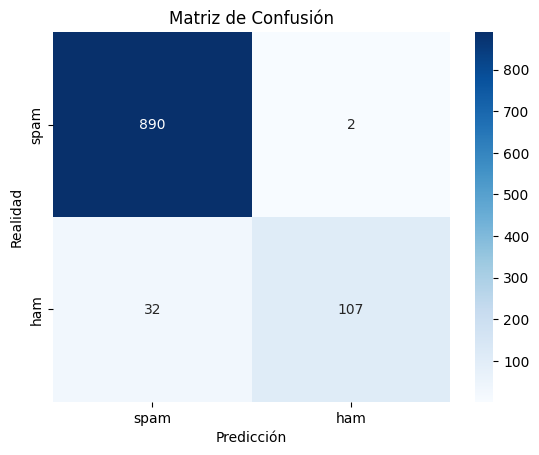

In [5]:
#entrenamiento de datos
print("\nentrenamiento de datos: ")

#entrenar el modelo con los datos
X = df['message']
y = df['category']

#separar los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#crear un pipeline para vectorizar y entrenar el modelo
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression())
])

#entrenar el pipeline
pipeline.fit(X_train, y_train)

#prredecir en el conjunto de prueba
y_pred = pipeline.predict(X_test)

#evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
confusion_matrix = confusion_matrix(y_test, y_pred) 
reporte = classification_report(y_test, y_pred)

print("Accuracy (exactitud):", accuracy)
print("Matriz de confusion:\n", confusion_matrix)
print("Reporte de clasificacion :\n", reporte)

#
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['spam', 'ham'], yticklabels=['spam', 'ham'])
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.title('Matriz de Confusión')
plt.show()

## 2.2 Construccion del modelo

In [98]:
#

## 2.3 Clasificicacion de mensajes futuros

In [99]:
#

## 2.4 Comparación con Librerías

In [9]:
# Librerias extra

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score


In [8]:
# Convierte los datos a números dando peso a las palabras
vectorizer = TfidfVectorizer()

model = make_pipeline(vectorizer, MultinomialNB())
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9485935984481086


### ¿Cuál implementación lo hizo mejor?
Nuestra implementación tuvo un accuracy de , mientras que la que se hizo utilizando librerías tuvo un accuracy de 0.95. Con esto podemos ver que la que tuvo un mejor desempeño fue

### ¿A qué se debe esta diferencia?